# Major assignment (BA885)
## Yipeng Guo/ ypguo@bu.edu
## Yilun Wang/ yilun830@bu.edu
In this assignment you will solve a deep learning problem from scratch!

Your company accepts payments over the phone for its services and is now in the process of automating this task. As the sole data scientist on your team, your task is to build and train a voice recognition algorithm to record the customer's credit card number. 






## **Questions**

### **1.What is the acceptable error rate for the model?**
Answer: Since our task is to build and train a voice recognition algorithm to record the customer's credit card number, the error rate should be low enough to make automatic payment a wonderful experience for clients. We think the error rate should be around 10% (accuracy at around 90%).

However, we chose to utilized the whole speech command dataset containing more than 38,000 samples, we achieved an accuracy rate of 92% (error rate of 8%), and we think that is good. But considering we would be having a limited sample set (self-collected sample), we shrinked the dataset to 3,000. That led to an accuracy of 63.56% (error rate of 36.44%). This, we think is kind of bad. It may cause troubles when applied in realistic.


### **2.What is the maximum accuracy you can reach with your limited (~3000) number of samples?**
Answer: Like we described before, we shuffled the dataset and chose to use only 3,000 sample (2,100 for training, 900 for testing). It turned out that we achieved an accuracy rate of approximately 64%. 

Considering build our self-collected dataset, we should be able to achieve similar accuracy.

### **3.Can you use data generation and transfer learning to improve the performance of your model?**

Answer: Sure, we can use data generation and transfer learning to improve model performance. Here we only built our model from scratch without utilizing any pre-trained model. We may try to do it.

However, there exists a problem. If we could have ~3,000 self-collected samples, either use transfer learning or not should only varies a little bit. But if we only have ~120 samples, utilizing transfer learning should make difference to the model. 

## Load Speech commands dataset

In [1]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 2.1 MB/s 


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shutil
import random
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from sklearn.utils import shuffle

In [3]:
_ = tf.keras.utils.get_file('speech_commands.tar.gz',
                            'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                            cache_dir='./',
                            cache_subdir='datasets',
                            extract=True)

2428936192/2428923189 [==============================] - 19s 0us/step


Generate dataset and labels according to number 1-9.

In [4]:
data = []
categories = []
labels_reverse_dict = { 'six': 6, 'eight': 8, 
                       'one': 1, 'seven': 7, 'nine': 9, 'five': 5, 'two': 2,
                       'three': 3, 'zero': 0, 'four': 4}

labels_dict = {y:x for x,y in labels_reverse_dict.items()}
            
for folder, labels, samples in os.walk('./datasets/'):
  if folder[11:] in labels_reverse_dict.keys():
    if folder[11:]:
        categories.append(folder[11:])
    for sample in samples:
        if sample[-3:] == 'wav':
            data.append([folder+'/'+sample, labels_reverse_dict[folder[11:]], folder[11:]])

Create dataframe and assign column names.

In [5]:
data1 = pd.DataFrame(data, columns=['filename', 'label', 'category'])
data1.head()

,filename,label,category
0,./datasets/five/bbc30633_nohash_3.wav,5,five
1,./datasets/five/578d3efb_nohash_0.wav,5,five
2,./datasets/five/c08585c1_nohash_0.wav,5,five
3,./datasets/five/86648261_nohash_0.wav,5,five
4,./datasets/five/9e2ce5e3_nohash_0.wav,5,five


In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38908 entries, 0 to 38907
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  38908 non-null  object
 1   label     38908 non-null  int64 
 2   category  38908 non-null  object
dtypes: int64(1), object(2)
memory usage: 912.0+ KB


In [7]:
# check categories
categories

['five',
 'four',
 'six',
 'one',
 'zero',
 'two',
 'eight',
 'nine',
 'three',
 'seven']

In [8]:
# check labels
labels_dict

{0: 'zero',
 1: 'one',
 2: 'two',
 3: 'three',
 4: 'four',
 5: 'five',
 6: 'six',
 7: 'seven',
 8: 'eight',
 9: 'nine'}

In [9]:
# check labels
data1['label'].unique()

array([5, 4, 6, 1, 0, 2, 8, 9, 3, 7])

In [10]:
# shuffle data1
data1_shuffled = data1.sample(frac = 1)

In [11]:
# split train/test data to 70/30
nums = 2100
train_data_paths = np.array(data1_shuffled['filename'][:nums])
train_labels = np.array(data1_shuffled['label'][:nums])
test_data_paths = np.array(data1_shuffled['filename'][nums:3000])
test_labels = np.array(data1_shuffled['label'][nums:3000])

In [12]:
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    return tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32) / 32767.0

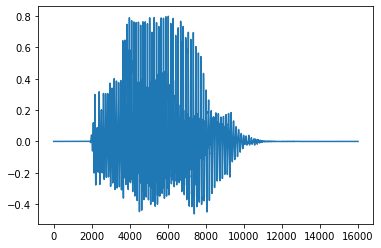

In [13]:
# make a test
testing_file = train_data_paths[-1]
testing_sample = load_audio(testing_file)


_ = plt.plot(testing_sample)

# Play the audio file.
display.Audio(testing_sample,rate=16000)

## Build our model

In [14]:
train_data = []
for path in train_data_paths:
    train_data.append(load_audio(path))

test_data = []
for path in test_data_paths:
    test_data.append(load_audio(path))

In [15]:
# check train data
train_data[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-9.1555528e-05, -9.1555528e-05, -1.5259255e-04, ...,
        1.2207404e-04,  9.1555528e-05,  1.8311106e-04], dtype=float32)>

In [16]:
# check test data
test_data[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 0.000000e+00, -3.051851e-05, -6.103702e-05, ..., -6.103702e-05,
       -6.103702e-05,  0.000000e+00], dtype=float32)>

In [17]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [18]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

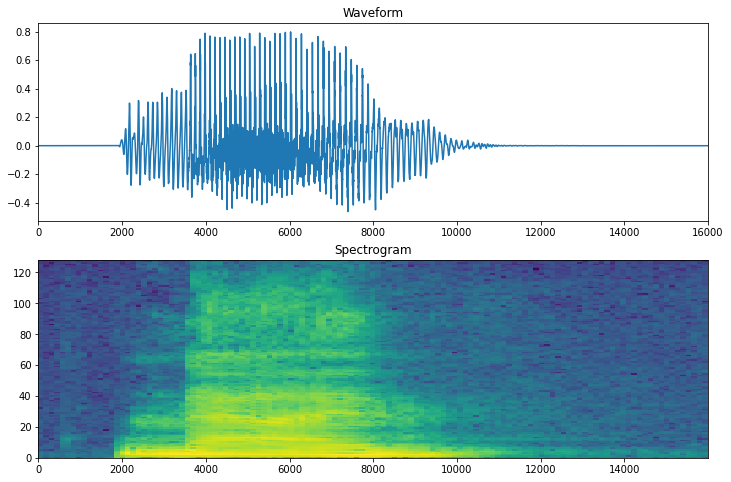

In [19]:
# testing:

waveform = testing_sample
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
display.Audio(testing_sample,rate=16000)

In [20]:
# get train data's spectrogram and check shape
train_data_s = []
for i in range(len(train_data)):
    train_data_s.append(get_spectrogram(train_data[i]))

train_data_s = np.array(train_data_s)
train_data_s.shape

(2100, 124, 129, 1)

In [21]:
# check shape of train label
train_labels.shape

(2100,)

In [23]:
input_shape

TensorShape([124, 129, 1])

In [22]:
# define model
input_shape = spectrogram.shape
num_labels = len(labels_dict)
model = keras.Sequential([layers.Input(shape=input_shape),
                          layers.Resizing(32, 32),
                          layers.Conv2D(32, 3, activation='relu'),
                          layers.Conv2D(64, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Dropout(0.25),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dropout(0.5),
                          layers.Dense(num_labels, activation='softmax'),
                          ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [24]:
#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [25]:
#callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                         patience=3, restore_best_weights=True)
callback = keras.callbacks.ModelCheckpoint("/content/model_1.h5",
                                           monitor='val_loss',
                                           save_weights_only=True,
                                           save_best_only=True)

model.fit(train_data_s, train_labels, epochs=60, batch_size=256,
          validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
7/7 [==============================] - 7s 830ms/step - loss: 2.1811 - accuracy: 0.2250 - val_loss: 1.9619 - val_accuracy: 0.3143
Epoch 2/60
7/7 [==============================] - 6s 791ms/step - loss: 1.8496 - accuracy: 0.3696 - val_loss: 1.7253 - val_accuracy: 0.4071
Epoch 3/60
7/7 [==============================] - 5s 786ms/step - loss: 1.6383 - accuracy: 0.4518 - val_loss: 1.5753 - val_accuracy: 0.4905
Epoch 4/60
7/7 [==============================] - 5s 783ms/step - loss: 1.4865 - accuracy: 0.5149 - val_loss: 1.5219 - val_accuracy: 0.5310
Epoch 5/60
7/7 [==============================] - 5s 783ms/step - loss: 1.3729 - accuracy: 0.5476 - val_loss: 1.4359 - val_accuracy: 0.5452
Epoch 6/60
7/7 [==============================] - 5s 784ms/step - loss: 1.2590 - accuracy: 0.5804 - val_loss: 1.3346 - val_accuracy: 0.5857
Epoch 7/60
7/7 [==============================] - 5s 783ms/step - loss: 1.1680 - accuracy: 0.6155 - val_loss: 1.2713 - val_accuracy: 0.6048
Epoch 8/60
7/7 [====

In [ ]:
# get train data's spectrogram and check shape
test_data_s = []
for i in range(len(test_data)):
    test_data_s.append(get_spectrogram(test_data[i]))

test_data_s = np.array(test_data_s)
test_data_s.shape

(900, 124, 129, 1)

In [ ]:
model.evaluate(test_data_s, test_labels)

29/29 [==============================] - 0s 4ms/step - loss: 1.3581 - accuracy: 0.7622


[1.3581312894821167, 0.7622222304344177]

After trained the model on 2,100 samples, the model can achieve 63.56% accuracy on 900 test samples. (We did a 70/30 train-test split)
